In [1]:
%matplotlib inline
import os
import scipy
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from plotnine import *
import arviz as az
import geopandas
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Data

In [2]:
# data
df = pd.read_csv('all_national_indicators.csv')
df.columns = df.columns.str.replace('.', '_')

# add climate
climate = pd.read_csv('meow_climatic_zone.csv', sep=';')
df = df.merge(climate[['iso3c', 'LAT_ZONE']], how='left', on='iso3c')

# remove NA climate
df = df[~df.LAT_ZONE.isnull()]

# add 'un_region_name' and 'un_subregion_2' to Taiwan
df.loc[df.country_name_en =='Taiwan', 'un_region_name'] = 'Asia'
df.loc[df.country_name_en =='Taiwan', 'un_subregion_2'] = 'Eastern Asia'

# new variables
df['mean_aquaculture_production'] = df[['mean_aquaculture_production_freshwater','mean_aquaculture_production_marine','mean_aquaculture_production_brackish']].sum(axis=1)
df['unit_exports'] = df['mean_exports_USD1000'] / df['mean_exports_tonnes']
df['unit_imports'] = df['mean_imports_USD1000'] / df['mean_imports_tonnes']

# log transform highly skewed variables
df['sat_model_est_wealth'] = np.log(df['sat_model_est_wealth'] + 1)
df['eez_total'] = np.log(df['eez_total'] + 1)
df['inland_water_max'] = np.log(df['inland_water_max'] + 1)
df['mean_capture_production'] = np.log(df['mean_capture_production'] + 1)
df['mean_aquaculture_production'] = np.log(df['mean_aquaculture_production'] + 1)
df['unit_exports'] = np.log(df['unit_exports'] + 1)
df['unit_imports'] = np.log(df['unit_imports'] + 1)

# response variable
y = df['mean_catch_nutrition_quality']

# scale to use the same prior for intercepts across models
q = np.nanquantile(y, [0.25, 0.75])
scale_factor =  100/(q[1] - q[0])
y_scaled = y * scale_factor
y_scaled = y_scaled[~y_scaled.isnull()].copy()

# predictor variables of inetrest
cov = ['mean_educ', 'sat_model_est_wealth', 'gender_equality', 'language_diversity',
    'cultural_hegemony', 'working_percent_un', 'mean_voice_account']

cov_name = ['Education', 'Wealth', 'Gender equality', 'Language diversity',
    'Cultural hegemony', 'Working population', 'Voice and accountability']

X = df[cov].copy()

# nuisance variables (climate)
climate = list(set(df.loc[y.index, 'LAT_ZONE']))
climate_dict = {x:i for i, x in enumerate(climate)}
climate_index = [climate_dict.get(x) for x in df.loc[y_scaled.index, 'LAT_ZONE']]

# add population (log) to help impute missing predictors
X['log_pop'] = np.log(df['mean_population']+ 1)

# standardize all predictors
def standardize(x):
    return (x-np.mean(x))/np.std(x)

X = X.apply(standardize, axis=0)
 
# remove predictors without a response variable
X = X.loc[y_scaled.index, :].copy()

In [3]:
X.head()

,mean_educ,sat_model_est_wealth,gender_equality,language_diversity,cultural_hegemony,working_percent_un,mean_voice_account,log_pop
0,0.279935,2.479917,NaN,0.888745,1.156119,3.146999,-1.033877,0.191508
1,NaN,-1.365754,-1.420207,1.163796,-1.059848,-1.687297,-1.226004,0.763701
2,-0.131998,0.138093,0.031861,0.212715,-1.059848,0.719520,0.121193,-0.258094
3,1.848803,-0.030343,-0.123827,-1.278527,-1.059848,0.770178,-0.642681,-0.259461
4,-1.257527,-1.040903,0.532070,1.024614,-1.059848,-1.991386,-1.141906,0.665242


In [4]:
y_scaled.head()

0    367.451252
1    721.149407
2    557.745689
3    481.955358
4    657.028909
Name: mean_catch_nutrition_quality, dtype: float64

#### _Mask NAs in predictors_

In [5]:
X_masked = np.ma.masked_invalid(X)

#### _Regional and national indices_

In [6]:
region = list(set(df.loc[X.index, 'un_subregion_2']))
region_dict = {x:i for i, x in enumerate(region)}
region_index = [region_dict.get(x) for x in df.loc[X.index, 'un_subregion_2']]
nation_index = list(range(X.shape[0]))

# Model

In [7]:
with pm.Model() as model:

    # global intercept and sd
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma_0 = pm.HalfCauchy('sigma_0', beta=5)

    # regional intercept
    mu_i_offset = pm.Normal('mu_i_offset', mu=0, sigma=1, shape=len(region))
    mu_i = pm.Deterministic('mu_i', mu_0 + mu_i_offset * sigma_0)
    alpha_i = pm.HalfCauchy('alpha_i', beta=5)
    beta_i = pm.HalfCauchy('beta_i', beta=5)
    sigma_i = pm.Gamma('sigma_i', alpha=alpha_i, beta=beta_i, shape=len(region))

    # national intercept
    mu_j_offset = pm.Normal('mu_j_offset', mu=0, sigma=1, shape=X.shape[0])
    mu_j = pm.Deterministic('mu_j', mu_i[region_index] + mu_j_offset[nation_index] * sigma_i[region_index])

    # climate intercept
    clim_ = pm.Normal('climate', mu=0, sigma=10, shape=len(climate)-1)
    clim = tt.set_subtensor(tt.zeros(shape=len(climate))[1:], clim_)

    # slope
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1]-1)   # removing log-population

    # error
    sigma = pm.HalfCauchy('sigma', beta=5)
    
    # impute missing X
    chol, _, _ = pm.LKJCholeskyCov('chol', n=X_masked.shape[1], eta=2, sd_dist=pm.Exponential.dist(lam=1), compute_corr=True)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    X_mu = pm.Normal('X_mu', mu=0, sigma=100, shape=X.shape[1], testval=X_masked.mean(axis=0))
    X_modeled = pm.MvNormal('X', mu=X_mu, chol=chol, observed=X_masked)

    # observation
    mu = mu_j[nation_index] + tt.dot(X_modeled[:,:-1], beta) + clim[climate_index]

    # likelihood
    likelihood = pm.StudentT('y', mu=mu, sigma=sigma, nu=5, observed=np.log(y_scaled))

#### _Sample_

In [8]:
with model:
    trace = pm.sample(5000, tune=1500, chains=2, target_accept=0.95)
    pp = pm.sample_posterior_predictive(trace)
    idata = az.from_pymc3(trace=trace, posterior_predictive=pp)

There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


#### _Trace plot_

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>],
       [<AxesSubplot:title={'center':'mu_i'}>,
        <AxesSubplot:title={'center':'mu_i'}>],
       [<AxesSubplot:title={'center':'mu_j'}>,
        <AxesSubplot:title={'center':'mu_j'}>],
       [<AxesSubplot:title={'center':'sigma_0'}>,
        <AxesSubplot:title={'center':'sigma_0'}>],
       [<AxesSubplot:title={'center':'sigma_i'}>,
        <AxesSubplot:title={'center':'sigma_i'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha_i'}>,
        <AxesSubplot:title={'center':'alpha_i'}>],
       [<AxesSubplot:title={'center':'beta_i'}>,
        <AxesSubplot:title={'center':'beta_i'}>],
       [<AxesSubplot:title={'center':'climate'}>,
        <AxesSubplot:title={'center':'climate'}>]], dtype=object)

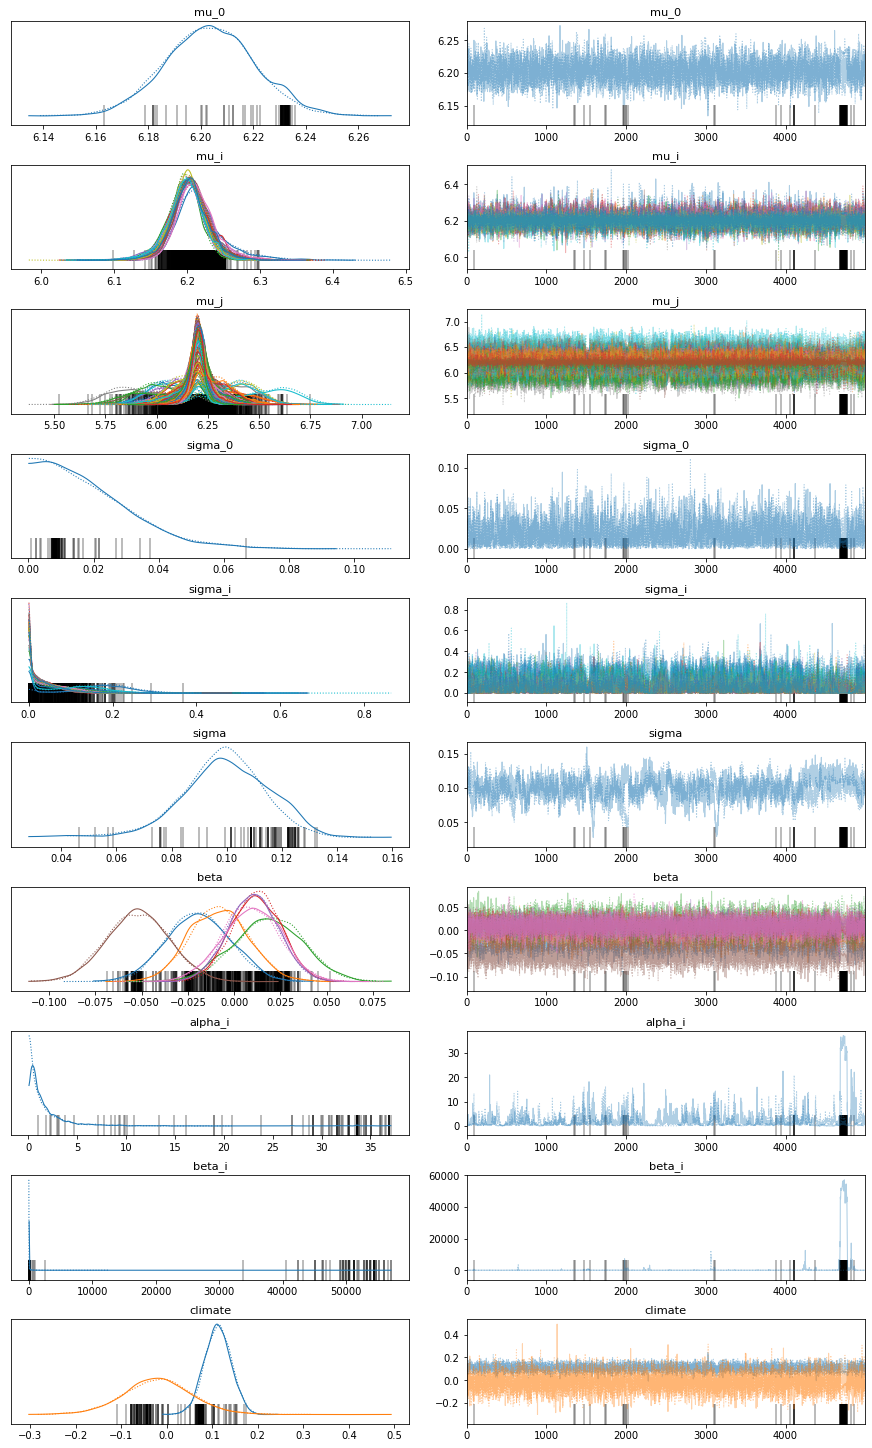

In [9]:
az.plot_trace(trace, var_names=['mu_0', 'mu_i', 'mu_j', 'sigma_0', 'sigma_i', 'sigma', 'beta', 'alpha_i', 'beta_i', 'climate'])

#### _LOO PIT_

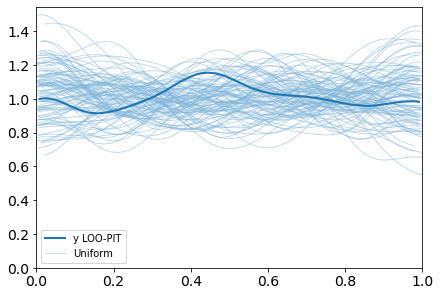

In [10]:
import matplotlib.pyplot as plt
az.plot_loo_pit(idata, y='y')
plt.savefig('plot/loo_pit/catch_quality.pdf')

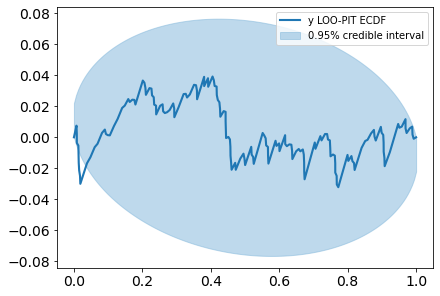

In [11]:
az.plot_loo_pit(idata, y='y', ecdf=True, hdi_prob=0.95)
plt.savefig('plot/loo_pit/catch_quality_ecdf.pdf')

In [12]:
idata.to_netcdf('output/inference/catch_quality.nc')

'output/inference/catch_quality.nc'

# Summary

In [13]:
summary_coef = np.quantile(trace.beta, axis=0, q=[0.5, 0.05, 0.25, 0.75, 0.95])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.index = X.columns[:-1]
summary_coef.columns = ['median', 'lower90', 'lower50', 'upper50', 'upper90']
summary_coef['rhat'] = az.rhat(trace).beta
summary_coef

/Users/shinn1/.pyenv/versions/pixel/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars


,median,lower90,lower50,upper50,upper90,rhat
mean_educ,-0.019451,-0.047125,-0.031064,-0.007549,0.009327,1.001083
sat_model_est_wealth,-0.008216,-0.034048,-0.019330,0.002606,0.018534,1.000866
gender_equality,0.018767,-0.012512,0.006163,0.031345,0.048502,1.001144
language_diversity,0.012039,-0.010257,0.002835,0.021240,0.033835,1.001644
cultural_hegemony,0.010322,-0.012023,0.001068,0.019369,0.032766,1.000533
working_percent_un,-0.052044,-0.079657,-0.063493,-0.040479,-0.023616,1.000117
mean_voice_account,0.009216,-0.017462,-0.001418,0.019947,0.034830,1.000468


In [14]:
summary_coef.to_csv('output/coef/coef_catch_quality.csv', index=True)

#### _Plot_

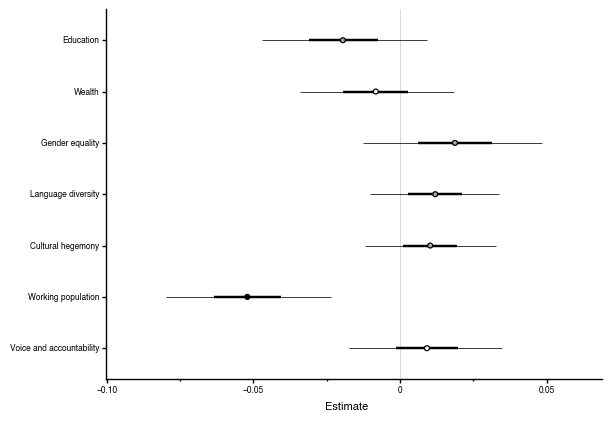

<ggplot: (331445637)>

In [15]:
summary_coef['var_name'] = cov_name
summary_coef = summary_coef[::-1]
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower90 * summary_coef.upper90, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range
min_val = summary_coef.lower90.min()
max_val = summary_coef.upper90.max()
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower90', ymax='upper90', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

In [16]:
ggsave(p, 'plot/coef/catch_quality.pdf', width=1.5, height=2.5)

#### _Nuisance_

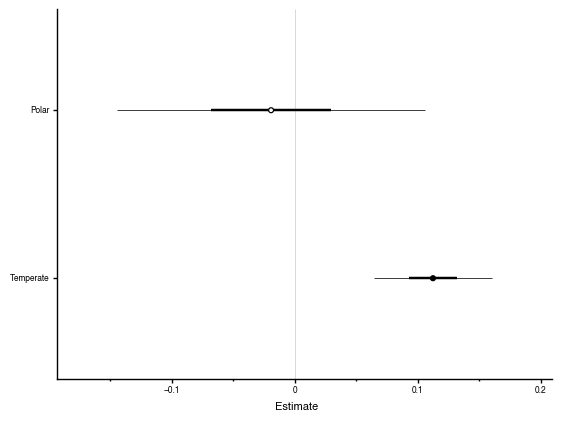

<ggplot: (334988857)>

In [17]:
summary_coef = np.quantile(trace.climate, axis=0, q=[0.5, 0.05, 0.25, 0.75, 0.95])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.columns = ['median', 'lower90', 'lower50', 'upper50', 'upper90']
summary_coef

climate
# plot
summary_coef['var_name'] = ['Temperate', 'Polar']
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower90 * summary_coef.upper90, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range
min_val = summary_coef.lower90.min()
max_val = summary_coef.upper90.max()
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower90', ymax='upper90', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

In [18]:
ggsave(p, 'plot/nuisance/catch_quality.pdf', width=1.5, height=2.5)

# Deviation analysis

In [19]:
# estimates for regional mu and sigma
mu_i = np.quantile(trace.mu_i, axis=0, q=0.5)
sigma_i = np.quantile(trace.sigma_i, axis=0, q=0.5)

data = pd.DataFrame()
data['region_index'] = region_index
data['region'] = [region[x] for x in data.region_index]
data['country'] = df.loc[y_scaled.index, 'country_name_en'].values
data['iso3'] = df.loc[y_scaled.index, 'iso3c'].values
data['mu_j'] = np.quantile(trace.mu_j, axis=0, q=0.5)
data['mu_i'] = [mu_i[x] for x in data.region_index]
data['sigma_i'] = [sigma_i[x] for x in data.region_index]
data['sd'] = (data.mu_j - data.mu_i)/data.sigma_i
data['region_intercept'] = np.exp(data.mu_i) / scale_factor
data['nation_intercept'] = np.exp(data.mu_j) / scale_factor
data.head()

,region_index,region,country,iso3,mu_j,mu_i,sigma_i,sd,region_intercept,nation_intercept
0,6,Western Asia,United Arab Emirates,ARE,6.188643,6.198619,0.028196,-0.353801,139.896916,138.508260
1,7,Southern Asia,Afghanistan,AFG,6.228794,6.204232,0.040046,0.613358,140.684431,144.182740
2,14,Southern Europe,Albania,ALB,6.212767,6.207931,0.024283,0.199176,141.205704,141.890323
3,6,Western Asia,Armenia,ARM,6.195324,6.198619,0.028196,-0.116853,139.896916,139.436740
4,12,Middle Africa,Angola,AGO,6.210913,6.204404,0.045693,0.142443,140.708595,141.627408


In [20]:
data.to_csv('output/sd/sd_catch_quality.csv', index=False)